 ## Продуктовая аналитика ##

### Задача 1 ###
В банке запустили аб-тест на странице, где можно оформить заявку на банковскую карту. В варианте А из 2574 клиентов, зашедших на страницу, на баннер нажали 350, в варианте Б из 2855 нажали 375. Какой вариант баннера предложить продакту и почему?

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Посчитаем CTR
clicks_A = 350
views_A = 2574
clicks_B = 375
views_B = 2855

ctr_A = clicks_A / views_A
ctr_B = clicks_B / views_B

print(f"CTR A: {ctr_A:.4f} ({ctr_A:.2%})")
print(f"CTR B: {ctr_B:.4f} ({ctr_B:.2%})")
print(f"Разница (A - B): {(ctr_A - ctr_B):.4f} ({(ctr_A - ctr_B)*100:.2f} п.п.)")

CTR A: 0.1360 (13.60%)
CTR B: 0.1313 (13.13%)
Разница (A - B): 0.0046 (0.46 п.п.)


С помощью статистического теста проверим статзначимость.
Для A/B-тестов с бинарным результатом (кликает / не кликает) подходит z-тест или хи-квадрат.

In [3]:
# Объединённая доля
p_pool = (clicks_A + clicks_B) / (views_A + views_B)

# Стандартная ошибка
se = np.sqrt(
    p_pool * (1 - p_pool) * (1/views_A + 1/views_B)
)

# Z-статистика
z = (ctr_A - ctr_B) / se

# P-value (двусторонний)
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z-статистика: {z:.4f}")
print(f"P-value: {p_value:.4f}")

Z-статистика: 0.5004
P-value: 0.6168


In [4]:
# Доверительные интервалы
def ci_proportion(clicks, views, alpha=0.05):
    ctr = clicks / views
    se = np.sqrt(ctr * (1 - ctr) / views)
    z_crit = stats.norm.ppf(1 - alpha/2)
    margin = z_crit * se
    return (ctr - margin, ctr + margin)

ci_A = ci_proportion(clicks_A, views_A)
ci_B = ci_proportion(clicks_B, views_B)

print(f"Доверительный интервал для A: [{ci_A[0]:.4f}, {ci_A[1]:.4f}]")
print(f"Доверительный интервал для B: [{ci_B[0]:.4f}, {ci_B[1]:.4f}]")

Доверительный интервал для A: [0.1227, 0.1492]
Доверительный интервал для B: [0.1190, 0.1437]


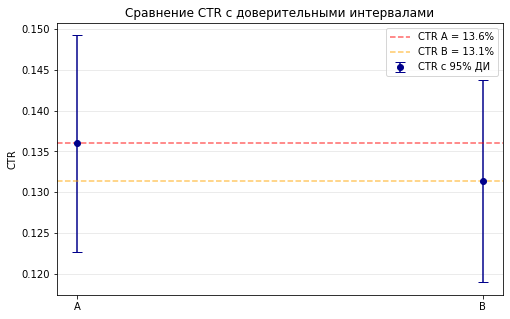

In [8]:
ci_A = ci_proportion(clicks_A, views_A)
ci_B = ci_proportion(clicks_B, views_B)

labels = ['A', 'B']
ctrs = [ctr_A, ctr_B]

cis = [ci_A, ci_B]

plt.figure(figsize=(8, 5))
plt.errorbar(labels, ctrs, yerr=yerr, fmt='o', capsize=5, 
             label='CTR с 95% ДИ', color='darkblue')

plt.axhline(y=ctr_A, color='red', linestyle='--', alpha=0.6, label=f'CTR A = {ctr_A:.1%}')
plt.axhline(y=ctr_B, color='orange', linestyle='--', alpha=0.6, label=f'CTR B = {ctr_B:.1%}')

plt.ylabel('CTR')
plt.title('Сравнение CTR с доверительными интервалами')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()

In [9]:
from scipy.stats import chi2_contingency

contingency = [[350, 2574 - 350],[375, 2855 - 375]]

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi²: {chi2:.4f}, p-value: {p:.4f}")

Chi²: 0.2120, p-value: 0.6452


Нет статистически значимой разницы между группами A и B. 

Разница в CTR (13.6% и 13.1%) может быть случайной .

In [10]:
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize
import numpy as np

# Исходные CTR
p_A = 350 / 2574   
p_B = 375 / 2855   

diff = p_A - p_B   

# Эффект-сайз (Cohen's h) — стандартная метрика для долей
effect_size = proportion_effectsize(prop1=p_A, prop2=p_B)

print(f"CTR A: {p_A:.4f} ({p_A:.2%})")
print(f"CTR B: {p_B:.4f} ({p_B:.2%})")
print(f"Разница: {diff:.4f} ({diff*100:.2f} п.п.)")
print(f"Effect size (Cohen's h): {effect_size:.4f}")

CTR A: 0.1360 (13.60%)
CTR B: 0.1313 (13.13%)
Разница: 0.0046 (0.46 п.п.)
Effect size (Cohen's h): 0.0136


In [11]:
# Расчёт необходимого размера выборки на группу
n_needed = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=0.05,
    power=0.8,           # мощность 80%
    alternative='two-sided'
)

print(f"Необходимый размер выборки на группу: {int(np.ceil(n_needed))}")

Необходимый размер выборки на группу: 84913


Чтобы с 80% вероятностью обнаружить разницу в 0.46 п.п. , нужно 84913 пользователей на группу. 
Текущая выборка недостаточна, высокий риск не заметить реальный эффект (ошибка 2 рода).
Увеличим разницу на 1 п.п.

In [12]:
# Базовый CTR и MDE
p_control = 0.1360
p_treatment = p_control + 0.01  # +1 п.п.
effect_size = proportion_effectsize(prop1=p_control, prop2=p_treatment)

# Расчёт объёма
n_needed = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=0.05,
    power=0.8,
    alternative='two-sided'
)

print(f"Effect size (Cohen's h): {effect_size:.4f}")
print(f"Необходимый размер выборки на группу: {int(n_needed)}")

Effect size (Cohen's h): -0.0287
Необходимый размер выборки на группу: 19007


0.46 /+ 1 п.п. — это небольшая, но потенциально ценная разница, особенно при высоком трафике. Но сейчас мы не можем быть уверены, что она реальна, потому что разница не статистически значима и для её обнаружения нужно больше данных.
Можно рекомендовать либо продолжить тест до необходимого количества пользователей на группу, либо внедрить A как потенциально лучший, но с рекомендацией мониторить метрики после запуска.

###  Задача 2 ###

Продукт хочет посчитать retention клиентов, узнать, какой процент клиентов вернулся в течение последующих месяцев после их первой покупки (retention).

 Вопросы для уточнения:
 
 
- По какому периоду (дни/недели/месяцы)?
 
- Как определяется "первый месяц" для retention?

- Нужен retention для всех клиентов?

- Сколько месяцев нужно проанализировать?

- Какие дополнительные метрики нужны?
Например, абсолютное количество клиентов, которые вернулись, или только проценты?

- Что считать первой покупкой и возвратом?

- Нужны ли сегменты?

- Интересует количество клиентов или выручка?

- Как часто обновлять?

Загружено 512 клиентов
Retention по дням:
    days_since_first  returning_clients  retention_rate
0                  0                512          100.00
1                  1                  1            0.20
2                  2                  1            0.20
3                  3                  0            0.00
4                  4                  0            0.00
5                  5                  1            0.20
6                  6                  1            0.20
7                  7                  3            0.59
8                  8                  4            0.78
9                  9                  4            0.78
10                10                  2            0.39
11                11                  1            0.20
12                12                  3            0.59
13                13                  0            0.00
14                14                  0            0.00
15                15                  0            0.00
16    

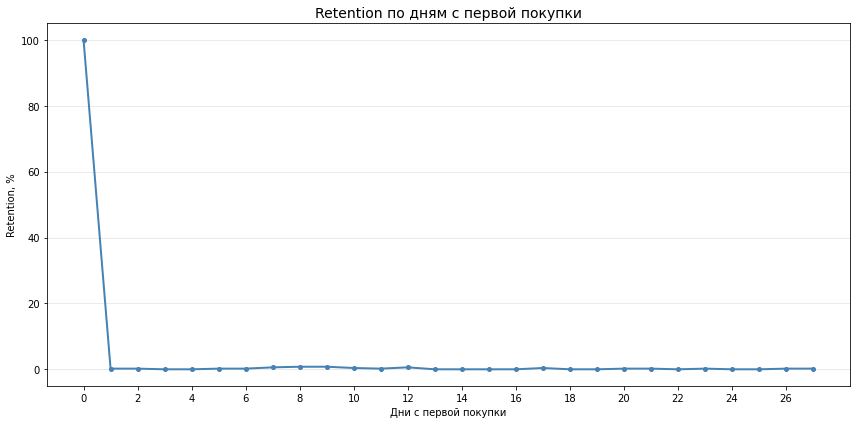

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем данные с автоматическим преобразованием дат
df = pd.read_csv('spending_last_30_days_with_dates.csv', 
                 parse_dates=['first_transaction_date', 'last_transaction_date', 'report_date'])

print(f"Загружено {len(df)} клиентов")

# Считаем разницу в днях и фильтруем отрицательные значения
df['days_since_first'] = (df['last_transaction_date'] - df['first_transaction_date']).dt.days
df = df[df['days_since_first'] >= 0].copy()

# Создаем данные для анализа retention: все клиенты в день 0 + повторные покупки
retention_data = pd.concat([
    pd.DataFrame({'id_client': df['id_client'], 'days_since_first': 0}),  # все в день 0
    df[df['days_since_first'] > 0][['id_client', 'days_since_first']]     # повторные покупки
], ignore_index=True)

# Группируем по дням и считаем уникальных клиентов
retention_summary = (retention_data
                    .groupby('days_since_first')['id_client']
                    .nunique()
                    .reset_index(name='returning_clients'))

# Считаем retention rate (%)
cohort_size = len(df)
retention_summary['retention_rate'] = (retention_summary['returning_clients'] / cohort_size * 100).round(2)

# Добавляем все дни от 0 до максимума (заполняем пропуски)
max_day = int(retention_summary['days_since_first'].max())
all_days = pd.DataFrame({'days_since_first': range(max_day + 1)})
retention_summary = (all_days
                    .merge(retention_summary, on='days_since_first', how='left')
                    .fillna({'returning_clients': 0})
                    .assign(returning_clients=lambda x: x['returning_clients'].astype(int)))

retention_summary['retention_rate'] = (retention_summary['returning_clients'] / cohort_size * 100).round(2)
retention_summary = retention_summary.sort_values('days_since_first').reset_index(drop=True)

print("Retention по дням:")
print(retention_summary)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(retention_summary['days_since_first'], retention_summary['retention_rate'],
         marker='o', linestyle='-', color='steelblue', linewidth=2, markersize=4)
plt.title('Retention по дням с первой покупки', fontsize=14)
plt.xlabel('Дни с первой покупки')
plt.ylabel('Retention, %')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, max_day + 1, max(1, max_day // 10)))
plt.tight_layout()
plt.show()